In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


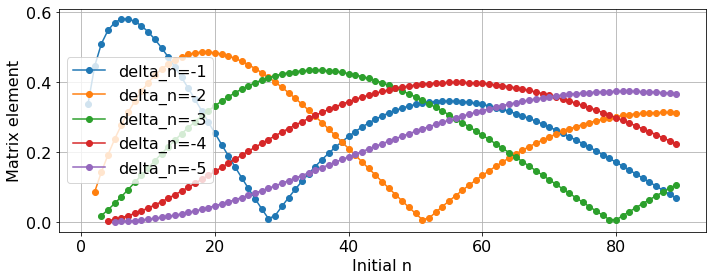

In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

n_range = 90
delta_ns = np.array([-1, -2, -3, -4, -5], dtype=int)

plt.figure(figsize=(10, 4))

for delta_n in delta_ns:
    # indices must be ints
    n_init = cp.arange(-delta_n, n_range, dtype=cp.int32)

    # vectorized gather on GPU
    vals = res.M[n_init, n_init + delta_n, 36]   # CuPy array

    # convert once for matplotlib
    x = cp.asnumpy(n_init)
    y = cp.asnumpy(vals)

    plt.plot(x, np.abs(y), '-o',label=f"delta_n={delta_n}")

plt.legend(fontsize=16)
plt.xlabel("Initial n", fontsize=16)
plt.ylabel("Matrix element", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()
plt.tight_layout()


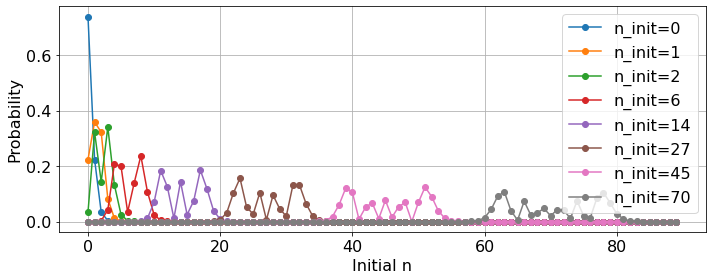

In [3]:
n_inits = np.array([0, 1, 2, 6, 14, 27, 45, 70], dtype=np.int32)
n_range = 90

plt.figure(figsize=(10, 4))
for n_init in n_inits:
    n_vals = cp.arange(0, n_range, dtype=cp.int32)

    vals = res.M[n_init, n_vals, 55]   # CuPy array

    # convert once for matplotlib
    x = cp.asnumpy(n_vals)
    y = cp.asnumpy(vals)

    plt.plot(x, y**2, '-o',label=f"n_init={n_init}")

plt.legend(fontsize=16)
plt.xlabel("Initial n", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()
plt.tight_layout()

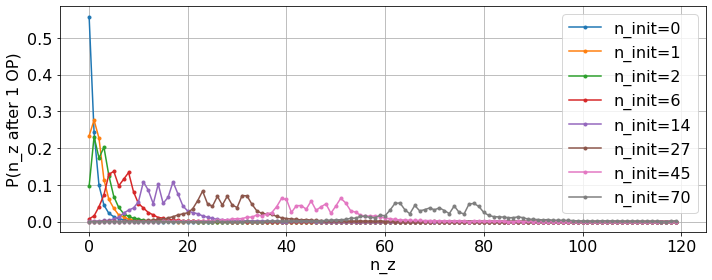

In [12]:
from cu_rsc.RSC_functions import op_test
n_inits = np.array([0, 1, 2, 6, 14, 27, 45, 70], dtype=np.int32)
n_range = 120
n_vals = np.arange(n_range)

Nmc = 10000  # Monte Carlo samples per initial state

plt.figure(figsize=(10, 4))

for n_init in n_inits:
    # IMPORTANT: molecules must be int32 with shape (N,6)
    mol = cp.zeros((Nmc, 6), dtype=cp.int32)
    mol[:, 2] = int(n_init)   # nz
    mol[:, 3] = -1            # state (so OP is active)
    mol[:, 4] = 0             # spin good
    mol[:, 5] = 0             # not lost

    # One optical pumping cycle
    op_test(mol, res, K_max=12, eta_op=0.55)

    # Keep only survivors if you want a conditional distribution
    surv = (mol[:, 5] == 0)
    nz = mol[surv, 2]

    # Histogram on GPU then move to CPU for plotting
    counts = cp.bincount(cp.clip(nz, 0, n_range - 1), minlength=n_range).astype(cp.float64)
    denom = int(surv.sum().get())
    prob = (counts / max(denom, 1)).get()

    plt.plot(n_vals, prob, '-o', markersize=3, label=f"n_init={n_init}")

plt.xlabel("n_z", fontsize=16)
plt.ylabel("P(n_z after 1 OP)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()


In [3]:
from cu_rsc.RSC_functions import convert_to_LD
convert_to_LD(cp.array([0., 0., 0.]), res.trap_freq[2])

array([0., 0., 0.])

In [7]:
res.M[2, 2, 0]

array(1., dtype=float32)